In [1]:
import numpy as np
import sympy
import scipy.optimize as opt
import copy
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from matplotlib import colors, ticker, cm
from scipy.sparse import spdiags
from scipy.sparse import eye

In [2]:
# Parameters
rho = 0.05
r = 0.05
delta = 0.05
c_param = 2
l_param = 2
B_param = 2

params = [rho, r, delta, c_param, l_param]

# Time parameters
T = 60 # length of lifespan
nT = 240 # number of time grids
dt = T/nT # Length of each time grid

# State space parameters
na = 50 # number of asset grid points
nk = 50 # number of human capital grid points

amin = 0
amax = 800

kmin = 1
kmax = 800

In [3]:
# Define utility functions
def u(c, c_param):
    return (c**(1-c_param))/(1-c_param)

def u_prime(c, c_param):
    return c**(-c_param)

def u_prime_inverse(x, c_param):
    return x**(-1/c_param)

def uh(h, l_param):
    return ((1-h)**(1-l_param))/(1-l_param)

def uh_prime(h, l_param):
    return -(1-h)**(-l_param)

def uh_prime_inverse(x, l_param):
    return 1 - ((-x)**(-1/l_param))

In [4]:
# Labor market functions
def g(x):
    return 1.25 - (x*(1.25**0.5 - 0.5) + 0.5)**2

def g_prime(x):
    return -2*(x*(1.25**0.5 - 0.5) + 0.5)*(1.25**0.5 - 0.5)

def g_prime_inverse(x):
    return (x/(-2*(1.25**0.5 - 0.5)) - 0.5)/(1.25**0.5 - 0.5)

Create grids

In [5]:
# State grids
a_vect = amin + np.linspace(0, 1, na)*(amax - amin) # Vector of A
da = (amax - amin)/(na - 1) # delta in A
aa = np.repeat(a_vect[:, None], nk, axis = 1) # Grid of A

k_vect = kmin + np.linspace(0, 1, nk)*(kmax - kmin) # Vector of A
dk = (kmax - kmin)/(nk - 1) # delta in K
kk = np.repeat(k_vect[None, :], na, axis = 0) # Grid of K

# Preallocate fwd/bwd derivatives, policy grid, value function grid
dVaF = np.zeros((na, nk))
dVaB = np.zeros((na, nk))
dVkF = np.zeros((na, nk))
dVkB = np.zeros((na, nk))

V_t = np.zeros((na, nk, nT+1))
C_t = np.zeros((na, nk, nT))
H_t = np.zeros((na, nk, nT))
X_t = np.zeros((na, nk, nT))
U_t = np.zeros((na, nk, nT))
mu_a_t = np.zeros((na, nk, nT))
mu_k_t = np.zeros((na, nk, nT))
dVa_t = np.zeros((na, nk, nT))
dVk_t = np.zeros((na, nk, nT))


# Arrays to store intermediate results for debugging
dUaF = np.zeros((na, nk))
dUaB = np.zeros((na, nk))
dUkF = np.zeros((na, nk))
dUkB = np.zeros((na, nk))

dUaF_t = np.zeros((na, nk, nT))
dUaB_t = np.zeros((na, nk, nT))
dUkF_t = np.zeros((na, nk, nT))
dUkB_t = np.zeros((na, nk, nT))

dVaF_t = np.zeros((na, nk, nT))
dVaB_t = np.zeros((na, nk, nT))
dVkF_t = np.zeros((na, nk, nT))
dVkB_t = np.zeros((na, nk, nT))
dVaS_t = np.zeros((na, nk, nT))
dVkS_t = np.zeros((na, nk, nT))
I_valid_t = np.zeros((na, nk, nT))
I_type_t = np.zeros((na, nk, nT))
I_unique_t = np.zeros((na, nk, nT))
I_stacked_t = np.zeros((na, nk, 5, nT))


# Terminal value
small_number1 = 10**(-16)
small_number2 = 10**(-16)
v_terminal = small_number1*((small_number2 + aa)**(1-B_param))/(1-B_param)

# Place terminal value into value function grid
V_t[:, :, nT] = v_terminal

Define functions that find dVa and dVk at boundaries a_min and k_min

In [6]:
# Drift functions
def drift_a(dVa, dVk, a, k, params):
    rho, r, delta, c_param, l_param = params
    c = u_prime_inverse(dVa, c_param)
    x = np.clip(g_prime_inverse(-dVk/dVa), 0, 1)
    h = np.clip(uh_prime_inverse(-dVa*g(x)*k - dVk*x*k, l_param), 0, 1)

    mu_a = r*a + g(x)*h*k - c
    return mu_a

def drift_k(dVk, dVa, a, k, params):
    rho, r, delta, c_param, l_param = params
    x = np.clip(g_prime_inverse(-dVk/dVa), 0, 1)
    h = np.clip(uh_prime_inverse(-dVa*g(x)*k - dVk*x*k, l_param), 0, 1)

    mu_k = x*h*k - delta*k
    return mu_k

In [7]:
def boundary_dVa(dVk, a, k, params):
    
    # Find dVa that leads to negative drift in a
    dVa_neg = 1
    while True:
        if drift_a(dVa_neg, dVk, a, k, params) < 0:
            break
        else:
            dVa_neg = dVa_neg/2

    # Find dVa that leads to positive drift in a
    dVa_pos = 1
    while True:
        if drift_a(dVa_pos, dVk, a, k, params) > 0:
            break
        else:
            dVa_pos = dVa_pos + 1

    # Use brentq to find the value of dVa where drift in a is 0, should be in between
    sol = opt.brentq(drift_a, dVa_neg, dVa_pos, args = (dVk, a, k, params), xtol = 1e-16, rtol = 1e-15)
    return sol

def boundary_dVk(dVa, a, k, params):
    
    # Find dVk that leads to negative drift in k
    dVk_neg = 1
    while True:
        if drift_k(dVk_neg, dVa, a, k, params) < 0:
            break
        else:
            dVk_neg = dVk_neg/2

    # Find dVk that leads to positive drift in k
    dVk_pos = 1
    while True:
        if drift_k(dVk_pos, dVa, a, k, params) > 0:
            break
        else:
            dVk_pos = dVk_pos + 1

    sol = opt.brentq(drift_k, dVk_neg, dVk_pos, args = (dVa, a, k, params), xtol = 1e-16, rtol = 1e-15)
    return sol

Find steady-state

In [8]:
# Define a function that computes mu_k for a given dVk where dVa is set to be such that mu_a=0
def drift_k_dVk(dVk, a, k, params):
    rho, r, delta, c_param, l_param = params

    # dVa that leads to mu_a = 0 for given dVk
    dVa = boundary_dVa(dVk, a, k, params)

    mu_k = drift_k(dVk, dVa, a, k, params)
    
    return mu_k

In [9]:
# Define a function that finds dVk that leads to mu_k=0 where dVa is set to be such that mu_a=0
def ss_dVk(a, k, params):
    rho, r, delta, c_param, l_param = params

    # Find dVk that leads to negative drift in k
    dVk_neg = 1
    while True:
        if drift_k_dVk(dVk_neg, a, k, params) < 0:
            break
        else:
            dVk_neg = dVk_neg/2

    # Find dVk that leads to positive drift in k
    dVk_pos = 1
    while True:
        if drift_k_dVk(dVk_pos, a, k, params) > 0:
            break
        else:
            dVk_pos = dVk_pos + 1

    sol = opt.brentq(drift_k_dVk, dVk_neg, dVk_pos, args = (a, k, params), xtol = 1e-16, rtol = 1e-15)

    return sol

In [10]:
# Define a function that computes controls and drifts for given dV and state
def control_drift(dVa, dVk, a, k, params):
    rho, r, delta, c_param, l_param = params

    c = u_prime_inverse(dVa, c_param)
    x = np.clip(g_prime_inverse(-dVk/dVa), 0, 1)
    h = np.clip(uh_prime_inverse(-dVa*g(x)*k - dVk*x*k, l_param), 0, 1)

    mu_a = r*a + g(x)*h*k - c
    mu_k = x*h*k - delta*k

    return c, h, x, mu_a, mu_k

In [11]:
# Find steady-state dVk0
dVk0 = np.zeros((na, nk))
dVa0 = np.zeros((na, nk))

for i in range(na):
    for j in range(nk):
        dVk0[i,j] = ss_dVk(aa[i,j], kk[i,j], params)
        dVa0[i,j] = boundary_dVa(dVk0[i,j], aa[i,j], kk[i,j], params)

In [12]:
# Fill in the rest of the steady-state values
C0, H0, X0, mu_a0, mu_k0 = control_drift(dVa0, dVk0, aa, kk, params)

Begin iterations

In [13]:
for t in range(nT-1, -1, -1):
    age = t*dt
    print(f'Age is {age}, t is {t}.')
    V = V_t[:, :, t+1]

    # Construct forward and backward differences for a and k
    dVaF[0:na-1, :] = (V[1:na, :] - V[0:na-1, :])/da
    dVaF[na-1, :] = dVaF[na-2, :]

    dVkF[:, 0:nk-1] = (V[:, 1:nk] - V[:, 0:nk-1])/dk
    dVkF[:, nk-1] = dVkF[:, nk-2]

    dVaB[1:na, :] = (V[1:na, :] - V[0:na-1, :])/da
    dVaB[0, :] = dVaB[1, :]

    dVkB[:, 1:nk] = (V[:, 1:nk] - V[:, 0:nk-1])/dk
    dVkB[:, 0] = dVkB[:, 1]

    # Verify value function is increasing in a
    if np.sum(dVaF < 0) > 0 or (np.sum(dVaB < 0) > 0): # Print message if there exists an element of dVa < 0
        print('V is not monotonically increasing in a')

    if (np.sum(dVkF < 0) > 0) or (np.sum(dVkB < 0) > 0): # Print message if there exists an element of dVk < 0
        print('V is not monotonically increasing in k')

    # Compute policies and drift
    cFF, hFF, xFF, mu_aFF, mu_kFF = control_drift(dVaF, dVkF, aa, kk, params)
    cFB, hFB, xFB, mu_aFB, mu_kFB = control_drift(dVaF, dVkB, aa, kk, params)
    cBF, hBF, xBF, mu_aBF, mu_kBF = control_drift(dVaB, dVkF, aa, kk, params)
    cBB, hBB, xBB, mu_aBB, mu_kBB = control_drift(dVaB, dVkB, aa, kk, params)

    # Create indicator matrices indicating consistency of direction of drift with fwd/bwd difference
    # Impose False at boundary if fwd/bwd difference implies drift sends state beyond boundary
    # Note that inconsistency may arise due to presence of steady-state in a or k or both dimensions. At the boundaries, these have to be checked for first before setting up reflecting boundaries, i.e., a may be already be decreasing at a_max but may show up as inconsistent if k is at steady-state, so setting up a reflecting boundary causes a to stay put instead of decreasing
    I_FF = np.logical_and(mu_aFF > 0, mu_kFF > 0)
    I_FF[na-1, :] = False
    I_FF[:, nk-1] = False

    I_FB = np.logical_and(mu_aFB > 0, mu_kFB < 0)
    I_FB[na-1, :] = False
    I_FB[:, 0] = False

    I_BF = np.logical_and(mu_aBF < 0, mu_kBF > 0)
    I_BF[0, :] = False
    I_BF[:, nk-1] = False

    I_BB = np.logical_and(mu_aBB < 0, mu_kBB < 0)
    I_BB[0, :] = False
    I_BB[:, 0] = False

    # Steady-state indicator
    I_SS = np.zeros((na, nk), dtype=bool)

    # Compute validity of fwd/bwd difference combinations
    # Stack all indicator matrices
    I_stacked = np.zeros((na, nk, 5))
    I_stacked[:, :, 0] = I_SS
    I_stacked[:, :, 1] = I_FF
    I_stacked[:, :, 2] = I_FB
    I_stacked[:, :, 3] = I_BF
    I_stacked[:, :, 4] = I_BB

    # Use logical-or over all 4 combinations; if at least one is valid, I_valid is True
    I_valid = np.logical_or.reduce((I_SS, I_FF, I_FB, I_BF, I_BB))

    # Check for uniqueness of valid combinations; some are not unique due to non-convexity of value function
    I_unique = np.sum(I_stacked, axis = 2) <= 1

    # Now perform tie-breaking by choosing combination that has largest Hamiltonian among valid combinations
    # Forward and backwards Hamiltonians
    H_FF = u(cFF, c_param) + uh(hFF, l_param) + mu_aFF*dVaF + mu_kFF*dVkF
    H_FB = u(cFB, c_param) + uh(hFB, l_param) + mu_aFB*dVaF + mu_kFB*dVkB
    H_BF = u(cBF, c_param) + uh(hBF, l_param) + mu_aBF*dVaB + mu_kBF*dVkF
    H_BB = u(cBB, c_param) + uh(hBB, l_param) + mu_aBB*dVaB + mu_kBB*dVkB
    H_stacked = np.zeros((na, nk, 5))
    H_stacked[:, :, 0] = -np.Inf
    H_stacked[:, :, 1] = H_FF
    H_stacked[:, :, 2] = H_FB
    H_stacked[:, :, 3] = H_BF
    H_stacked[:, :, 4] = H_BB

    # Take values of Hamiltonians if combination is valid; -inf otherwise
    H_valid = np.where(I_stacked, H_stacked, -np.Inf)

    # This selects the combination with the largest Hamiltonian among all valid combinations
    I_type = np.argmax(H_valid, axis = 2)

    # Create matrices for boundary conditions and interior steady-states
    dVaS = np.zeros((na, nk))
    dVkS = np.zeros((na, nk))
    mu_aSF = np.zeros((na, nk))
    mu_aSB = np.zeros((na, nk))
    mu_aFS = np.zeros((na, nk))
    mu_aBS = np.zeros((na, nk))
    mu_kSF = np.zeros((na, nk))
    mu_kSB = np.zeros((na, nk))
    mu_kFS = np.zeros((na, nk))
    mu_kBS = np.zeros((na, nk))
    

    # Check for steady-states at the boundaries
    # Steady-state k at a_min
    i = 0
    for j in range(1, nk-1):
        if (I_valid[i, j] == False) and (mu_aFF[i, j] > 0) and (mu_aFB[i, j] > 0):
            #print('k is steady-state')

            # Need to find dVk such that mu_k = 0
            dVaij = dVaF[i, j]
            aij = aa[i, j]
            kij = kk[i, j]

            dVkij = boundary_dVk(dVaij, aij, kij, params)

            # Policy and drift
            cij, hij, xij, mu_aij, mu_kij = control_drift(dVaij, dVkij, aij, kij, params)

            # If FS is consistent:
            if (mu_aij > 0):
                dVkS[i, j] = dVkij
                mu_aFS[i, j] = mu_aij
                mu_kFS[i, j] = mu_kij

                I_valid[i, j] = True
                I_type[i, j] = 7

    # Steady-state k at a_max
    i = na-1
    for j in range(1, nk-1):
        if (I_valid[i, j] == False) and (mu_aBF[i, j] < 0) and (mu_aBB[i, j] < 0):
            #print('k is steady-state')

            # Need to find dVk such that mu_k = 0
            dVaij = dVaB[i, j]
            aij = aa[i, j]
            kij = kk[i, j]

            dVkij = boundary_dVk(dVaij, aij, kij, params)

            # Policy and drift
            cij, hij, xij, mu_aij, mu_kij = control_drift(dVaij, dVkij, aij, kij, params)

            # If BS is consistent:
            if (mu_aij < 0):
                dVkS[i, j] = dVkij
                mu_aBS[i, j] = mu_aij
                mu_kBS[i, j] = mu_kij

                I_valid[i, j] = True
                I_type[i, j] = 8

    # Steady-state a at k_min
    j = 0
    for i in range(1, na-1):
        if (I_valid[i, j] == False) and (mu_kFF[i, j] > 0) and (mu_kBF[i, j] > 0):
            #print('a is steady-state')

            # Need to find dVa such that mu_a = 0
            dVkij = dVkF[i, j]
            aij = aa[i, j]
            kij = kk[i, j]

            dVaij = boundary_dVa(dVkij, aij, kij, params)

            # Policy and drift
            cij, hij, xij, mu_aij, mu_kij = control_drift(dVaij, dVkij, aij, kij, params)

            # If SF is consistent:
            if (mu_kij > 0):
                dVaS[i, j] = dVaij
                mu_aSF[i, j] = mu_aij
                mu_kSF[i, j] = mu_kij

                I_valid[i, j] = True
                I_type[i, j] = 5

    # Steady-state a at k_max
    j = nk-1
    for i in range(1, na-1):
        if (I_valid[i, j] == False) and (mu_kFB[i, j] < 0) and (mu_kBB[i, j] < 0):
            #print('a is steady-state')

            # Need to find dVa such that mu_a = 0
            dVkij = dVkB[i, j]
            aij = aa[i, j]
            kij = kk[i, j]

            dVaij = boundary_dVa(dVkij, aij, kij, params)

            # Policy and drift
            cij, hij, xij, mu_aij, mu_kij = control_drift(dVaij, dVkij, aij, kij, params)

            # If SB is consistent:
            if (mu_kij < 0):
                dVaS[i, j] = dVaij
                mu_aSB[i, j] = mu_aij
                mu_kSB[i, j] = mu_kij

                I_valid[i, j] = True
                I_type[i, j] = 6
    
    # Set up reflecting boundary condition at a_min
    # Loop over a_min (upper edge) in the j dimension
    i = 0
    for j in range(nk):
        if I_valid[i, j] == False:
            aij = aa[i, j]
            kij = kk[i, j]

            # Try SF scheme, so use dVkF
            dVkij = dVkF[i, j]

            # Find dVaS that satisfies FOCs and a_min boundary condition
            dVaij = boundary_dVa(dVkij, aij, kij, params)

            # Compute drift and evaluate if drift is consistent with chosen fwd diff for k
            cij, hij, xij, mu_aij, mu_kij = control_drift(dVaij, dVkij, aij, kij, params)

            # Check consistency of upwind scheme
            if (mu_kij >= 0) and (j != nk-1):
                # fwd diff for k is successful; SF scheme works
                I_valid[i, j] = True
                I_type[i, j] = 5

                # Boundary dVaS
                dVaS[i, j] = dVaij

                # Drift values
                mu_aSF[i, j] = mu_aij
                mu_kSF[i, j] = mu_kij

            # SF scheme failed; try SB scheme
            else:
                dVkij = dVkB[i, j]
                dVaij = boundary_dVa(dVkij, aij, kij, params)
                cij, hij, xij, mu_aij, mu_kij = control_drift(dVaij, dVkij, aij, kij, params)

                if (mu_kij <= 0) and (j != 0):
                    # bwd diff for k is successful; SB scheme works
                    I_valid[i, j] = True
                    I_type[i, j] = 6

                    # Boundary dVaS
                    dVaS[i, j] = dVaij

                    # Drift values
                    mu_aSB[i, j] = mu_aij
                    mu_kSB[i, j] = mu_kij

    # Set up reflecting boundary condition at a_max
    # Loop over a_max (lower edge) in the j dimension
    i = na-1
    for j in range(nk):
        if I_valid[i, j] == False:
            if (j > 0) and (j < nk-1):
                print("a_max too small")
            
            aij = aa[i, j]
            kij = kk[i, j]

            # Try SF scheme, so use dVkF
            dVkij = dVkF[i, j]

            # Find dVaS that satisfies FOCs and a_max boundary condition
            dVaij = boundary_dVa(dVkij, aij, kij, params)

            # Compute drift and evaluate if drift is consistent with chosen fwd diff for k
            cij, hij, xij, mu_aij, mu_kij = control_drift(dVaij, dVkij, aij, kij, params)

            if (mu_kij >= 0) and (j != nk-1):
                # fwd diff for k is successful; SF scheme works
                I_valid[i, j] = True
                I_type[i, j] = 5

                # Boundary condition dVaS
                dVaS[i, j] = dVaij

                # Drift values
                mu_aSF[i, j] = mu_aij
                mu_kSF[i, j] = mu_kij

            # SF scheme failed; try SB scheme
            else:
                dVkij = dVkB[i, j]
                dVaij = boundary_dVa(dVkij, aij, kij, params)
                cij, hij, xij, mu_aij, mu_kij = control_drift(dVaij, dVkij, aij, kij, params)

                if (mu_kij <= 0) and (j != 0):
                    # bwd diff for k is successful; BB scheme works
                    I_valid[i, j] = True
                    I_type[i, j] = 6

                    # Boundary dVaS
                    dVaS[i, j] = dVaij

                    # Drift values
                    mu_aSB[i, j] = mu_aij
                    mu_kSB[i, j] = mu_kij

    # Set up reflecting boundary condition at k_min
    # Loop over k_min (left edge) in the i dimension
    j = 0
    for i in range(na):
        if I_valid[i, j] == False:
            aij = aa[i, j]
            kij = kk[i, j]

            # Try FS scheme, so use dVaF
            dVaij = dVaF[i, j]

            # Find dVkS that satisfies FOC and k_min boundary condition
            dVkij = boundary_dVk(dVaij, aij, kij, params)

            # Compute drift and evaluate if drift is consistent with chosen fwd diff for a
            cij, hij, xij, mu_aij, mu_kij = control_drift(dVaij, dVkij, aij, kij, params)

            if (mu_aij >= 0) and (i != na):
                # fwd diff for a is successful; FS scheme works
                I_valid[i, j] = True
                I_type[i, j] = 7

                # Boundary condition dVkS
                dVkS[i, j] = dVkij

                # Drift values
                mu_aFS[i, j] = mu_aij
                mu_kFS[i, j] = mu_kij

            # FS scheme failed, try BS
            else:
                dVaij = dVaB[i, j]
                dVkij = boundary_dVk(dVaij, aij, kij, params)
                cij, hij, xij, mu_aij, mu_kij = control_drift(dVaij, dVkij, aij, kij, params)

                if (mu_aij <= 0) and (i != 0):
                    # bwd diff for a is successful; BS scheme works
                    I_valid[i, j] = True
                    I_type[i, j] = 8

                    # Boundary condition dVkS
                    dVkS[i, j] = dVkij

                    # Replace bwd diff drift values
                    mu_aBS[i, j] = mu_aij
                    mu_kBS[i, j] = mu_kij

    # Set up reflecting boundary condition at k_max
    # Loop over k_max (upper edge) in the i dimension
    j = nk-1
    for i in range(na):
        if I_valid[i, j] == False:
            if (i > 0) and (i < na-1):
                print("k_max too small")
            
            aij = aa[i, j]
            kij = kk[i, j]

            # Try FS scheme, so use dVaF
            dVaij = dVaF[i, j]

            # Find dVkS that satisfies FOC and k_max boundary condition
            dVkij = boundary_dVk(dVaij, aij, kij, params)

            # Compute drift and evaluate if drift is consistent with chosen fwd diff for a
            cij, hij, xij, mu_aij, mu_kij = control_drift(dVaij, dVkij, aij, kij, params)

            if (mu_aij >= 0) and (i != na):
                # fwd diff for a is successful; FS scheme works
                I_valid[i, j] = True
                I_type[i, j] = 7

                # Boundary condition dVkS
                dVkS[i, j] = dVkij

                # Drift values
                mu_aFS[i, j] = mu_aij
                mu_kFS[i, j] = mu_kij

            # FS scheme failed, try BS
            else:
                dVaij = dVaB[i, j]

                # Find dVkF that satisfies FOC and k_min boundary condition
                dVkij = boundary_dVk(dVaij, aij, kij, params)

                # Compute drift and evaluate if drift is consistent with chosen fwd diff for a
                cij, hij, xij, mu_aij, mu_kij = control_drift(dVaij, dVkij, aij, kij, params)

                if (mu_aij <= 0) and (i != 0):
                    # bwd diff for a is successful; BF scheme works
                    I_valid[i, j] = True
                    I_type[i, j] = 8

                    # Boundary condition dVkS
                    dVkS[i, j] = dVkij

                    # Replace bwd diff drift values
                    mu_aBS[i, j] = mu_aij
                    mu_kBS[i, j] = mu_kij

    # Look for a or k steady-states in the interior
    for i in range(1, na-1):
        for j in range(1, nk-1):
            if I_valid[i, j] == False:

                aij = aa[i, j]
                kij = kk[i, j]

                dVaijF = dVaF[i, j]
                dVaijB = dVaB[i, j]
                dVkijF = dVkF[i, j]
                dVkijB = dVkB[i, j]

                # Check consistency
                mu_aijFF = mu_aFF[i, j]
                mu_kijFF = mu_kFF[i, j]

                mu_aijFB = mu_aFB[i, j]
                mu_kijFB = mu_kFB[i, j]

                mu_aijBF = mu_aBF[i, j]
                mu_kijBF = mu_kBF[i, j]

                mu_aijBB = mu_aBB[i, j]
                mu_kijBB = mu_kBB[i, j]

                # aF is consistent if a wants to increase for both dVkF and dVkB
                aF_consistent = ((mu_aijFF > 0) and (mu_aijFB > 0))
                aB_consistent = ((mu_aijBF < 0) and (mu_aijBB < 0))
                kF_consistent = ((mu_kijFF > 0) and (mu_kijBF > 0))
                kB_consistent = ((mu_kijFB < 0) and (mu_kijBB < 0))

                # a is steady-statekijFB < 0) and (mu_kijBB < 0))
                a_consistent = (aF_consistent or aB_consistent)
                k_consistent = (kF_consistent or kB_consistent)

                # k is steady-state
                if (a_consistent == True) and (k_consistent == False):
                    #print('k is steady-state')

                    # k is steady-state, so need to find dVk such that mu_k = 0
                    # First try FS scheme
                    dVaij = dVaF[i, j]

                    # Find dVk that leads to mu_k = 0
                    dVkij = boundary_dVk(dVaij, aij, kij, params)

                    # Policy and drift
                    cij, hij, xij, mu_aij, mu_kij = control_drift(dVaij, dVkij, aij, kij, params)

                    # If FS is consistent:
                    if mu_aij > 0:
                        dVkS[i, j] = dVkij
                        mu_aFS[i, j] = mu_aij
                        mu_kFS[i, j] = mu_kij

                        I_valid[i, j] = True
                        I_type[i, j] = 7

                    # FS scheme failed; try BS scheme
                    else:
                        dVaij = dVaB[i, j]

                        # Find dVk that leads to mu_k = 0
                        dVkij = boundary_dVk(dVaij, aij, kij, params)

                        # Policy and drift
                        cij, hij, xij, mu_aij, mu_kij = control_drift(dVaij, dVkij, aij, kij, params)

                        # If BS is consistent:
                        if mu_aij < 0:
                            dVkS[i, j] = dVkij

                            # Both a and k are steady-state in j
                            mu_aBS[i, j] = mu_aij
                            mu_kBS[i, j] = mu_kij

                            I_valid[i, j] = True
                            I_type[i, j] = 8


                if (a_consistent == False) and (k_consistent == True):
                    #print('a is steady-state')

                    # a is steady-state, so need to find dVa such that mu_a = 0
                    # First try SF scheme
                    dVkij = dVkF[i, j]

                    # Find dVk that leads to mu_k = 0
                    dVaij = boundary_dVa(dVkij, aij, kij, params)

                    # Policy and drift
                    cij, hij, xij, mu_aij, mu_kij = control_drift(dVaij, dVkij, aij, kij, params)

                    # If SF is consistent:
                    if mu_kij > 0:
                        dVaS[i, j] = dVaij
                        mu_aSF[i, j] = mu_aij
                        mu_kSF[i, j] = mu_kij

                        I_valid[i, j] = True
                        I_type[i, j] = 5

                    # SF scheme failed; try SB scheme
                    else:
                        dVkij = dVkB[i, j]

                        # Find dVk that leads to mu_k = 0
                        dVaij = boundary_dVa(dVkij, aij, kij, params)

                        # Policy and drift
                        cij, hij, xij, mu_aij, mu_kij = control_drift(dVaij, dVkij, aij, kij, params)

                        # If BS is consistent:
                        if mu_kij < 0:
                            dVaS[i, j] = dVaij
                            mu_aSB[i, j] = mu_aij
                            mu_kSB[i, j] = mu_kij

                            I_valid[i, j] = True
                            I_type[i, j] = 6

    # Need to check that drifts are negative at upper bound

    
    # Construct dVa and dVk matrices
    # If no scheme is valid, use steady-state values, i.e. stay put
    # Note: SS is I_type == 0, FF == 1, FB == 2, BF == 3, BB == 4, SF == 5, SB == 6, FS == 7, BS == 8 
    dVa = (dVaF*(I_type == 1) + dVaF*(I_type == 2) + dVaB*(I_type == 3) + dVaB*(I_type == 4) + dVaS*(I_type == 5) + dVaS*(I_type == 6) + dVaF*(I_type == 7) + dVaB*(I_type == 8))*I_valid + dVa0*(~I_valid)
    dVk = (dVkF*(I_type == 1) + dVkB*(I_type == 2) + dVkF*(I_type == 3) + dVkB*(I_type == 4) + dVkF*(I_type == 5) + dVkB*(I_type == 6) + dVkS*(I_type == 7) + dVkS*(I_type == 8))*I_valid + dVk0*(~I_valid)

    # Construct policy functions and utility
    C, H, X, mu_a, mu_k = control_drift(dVa, dVk, aa, kk, params)
    U = u(C, c_param) + uh(H, l_param)

    # Construct sparse diagonal matrix A
    # Reshape mu_a using column-major (Fortran) order
    mu_a_diag = np.reshape(mu_a, na*nk, order='F')/da

    # -1 diagonal is mu_a<0, +1 diag is mu>0
    # Shift elements forward 1 index as placement in upper diagonal in spdiags lops off the first element. Want diagonal to start with the 1st element.
    mu_a_diag_pos = np.roll(np.clip(mu_a_diag, 0, None), 1)

    # Shift elements back 1 index as placement in lower diagonal in spdiags lops off the last element. Want diagonal to start with the 2nd element.
    mu_a_diag_neg = np.roll(-np.clip(mu_a_diag, None, 0), -1) 

    # Reshape mu_k using column-major (Fortran) order
    mu_k_diag = np.reshape(mu_k, na*nk, order='F')/dk

    # -na diag is mu_k < 0, +na diag is mu_k > 0
    # Shift elements forward na index as placement in upper diagonal in spdiags lops off the first na elements. Want diagonal to start with 1st element.
    mu_k_diag_pos = np.roll(np.clip(mu_k_diag, 0, None), na)

    # Shift elements back na index as placement in lower diagonal in spdiags lops off the last na elements. Want diagonal to start with the na'th element
    mu_k_diag_neg = np.roll(-np.clip(mu_k_diag, None, 0), -na)

    # Construct main diagonal
    main_diag = np.reshape(-np.abs(mu_a)/da - np.abs(mu_k)/dk, na*nk, order='F')

    A = spdiags(np.array([mu_k_diag_neg, mu_a_diag_neg, main_diag, mu_a_diag_pos, mu_k_diag_pos]), np.array([-na, -1, 0, 1, na]), na*nk, na*nk)

    # Solve set of linear equations to obtain V for current period from V of next period
    b = np.reshape(U + V/dt, na*nk, order='F')
    B = (1/dt + rho)*np.identity(na*nk) - A
    V_stacked = np.linalg.solve(B, b)

    V_t[:, :, t] = copy.copy(np.reshape(V_stacked, (na, nk), order = 'F'))

    # Store results for debugging
    C_t[:, :, t] = copy.copy(C)
    H_t[:, :, t] = copy.copy(H)
    X = np.where(H == 0, -1, X)
    X_t[:, :, t] = copy.copy(X)
    U_t[:, :, t] = copy.copy(U)

    mu_a_t[:, :, t] = copy.copy(mu_a)
    mu_k_t[:, :, t] = copy.copy(mu_k)

    dVaF_t[:, :, t] = copy.copy(dVaF)
    dVaB_t[:, :, t] = copy.copy(dVaB)
    dVaS_t[:, :, t] = copy.copy(dVaS)
    dVkF_t[:, :, t] = copy.copy(dVkF)
    dVkB_t[:, :, t] = copy.copy(dVkB)
    dVkS_t[:, :, t] = copy.copy(dVkS)

    dVa_t[:, :, t] = copy.copy(dVa)
    dVk_t[:, :, t] = copy.copy(dVk)

    I_valid_t[:, :, t] = copy.copy(I_valid)
    I_type_t[:, :, t] = copy.copy(I_type)
    I_unique_t[:, :, t] = copy.copy(I_unique)
    I_stacked_t[:, :, :, t] = copy.copy(I_stacked)

Age is 59.75, t is 239.
Age is 59.5, t is 238.
Age is 59.25, t is 237.
Age is 59.0, t is 236.
Age is 58.75, t is 235.
Age is 58.5, t is 234.
Age is 58.25, t is 233.
Age is 58.0, t is 232.
Age is 57.75, t is 231.
Age is 57.5, t is 230.
Age is 57.25, t is 229.
Age is 57.0, t is 228.
Age is 56.75, t is 227.
Age is 56.5, t is 226.
Age is 56.25, t is 225.
Age is 56.0, t is 224.
Age is 55.75, t is 223.
Age is 55.5, t is 222.
Age is 55.25, t is 221.
Age is 55.0, t is 220.
Age is 54.75, t is 219.
Age is 54.5, t is 218.
Age is 54.25, t is 217.
Age is 54.0, t is 216.
Age is 53.75, t is 215.
Age is 53.5, t is 214.
Age is 53.25, t is 213.
Age is 53.0, t is 212.
Age is 52.75, t is 211.
Age is 52.5, t is 210.
Age is 52.25, t is 209.
Age is 52.0, t is 208.
Age is 51.75, t is 207.
Age is 51.5, t is 206.
Age is 51.25, t is 205.
Age is 51.0, t is 204.
Age is 50.75, t is 203.
Age is 50.5, t is 202.
Age is 50.25, t is 201.
Age is 50.0, t is 200.
Age is 49.75, t is 199.
Age is 49.5, t is 198.
Age is 49.25,

In [14]:
V_t[:, :, 27]

array([[-76.91244194, -27.73475906, -25.389483  , ..., -20.14061985,
        -20.1229474 , -20.10584428],
       [-41.67365261, -26.64238098, -24.85659872, ..., -20.10906969,
        -20.09212386, -20.07571571],
       [-30.83878791, -25.88044981, -24.44927686, ..., -20.07777253,
        -20.06154314, -20.04582041],
       ...,
       [-20.04109752, -19.53231135, -19.35714603, ..., -19.0512506 ,
        -19.05103321, -19.05082552],
       [-20.0314492 , -19.52266536, -19.34750243, ..., -19.04167114,
        -19.0414545 , -19.04124753],
       [-20.02219574, -19.51341415, -19.33825353, ..., -19.03248437,
        -19.03226844, -19.03206218]])

In [15]:
np.sum(dVaF_t[:, :, 0] < 0)

0

In [16]:
dVaB_t[:, :, 27]

array([[2.15649602e+00, 6.69070581e-02, 3.26388009e-02, ...,
        1.93209454e-03, 1.88759931e-03, 1.84504133e-03],
       [2.15649602e+00, 6.69070581e-02, 3.26388009e-02, ...,
        1.93209454e-03, 1.88759931e-03, 1.84504133e-03],
       [6.62966859e-01, 4.66728185e-02, 2.49509255e-02, ...,
        1.91659601e-03, 1.87272395e-03, 1.83075156e-03],
       ...,
       [6.15771184e-04, 6.15619716e-04, 6.15464516e-04, ...,
        6.11330028e-04, 6.11282045e-04, 6.11235082e-04],
       [5.90040636e-04, 5.89894231e-04, 5.89744167e-04, ...,
        5.85743296e-04, 5.85697099e-04, 5.85651900e-04],
       [5.65892261e-04, 5.65750733e-04, 5.65605614e-04, ...,
        5.61730782e-04, 5.61686228e-04, 5.61642650e-04]])

In [17]:
np.sum(dVaF_t[:, :, 41] < 0, axis = 0)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [18]:
dVaF_t[3, 3, 41]

0.015547194959943535

In [19]:
V = V_t[:, :, 27]

# Construct forward and backward differences for a and k
dVaF[0:na-1, :] = (V[1:na, :] - V[0:na-1, :])/da
dVaF[na-1, :] = dVaF[na-2, :]

dVkF[:, 0:nk-1] = (V[:, 1:nk] - V[:, 0:nk-1])/dk
dVkF[:, nk-1] = dVkF[:, nk-2]

dVaB[1:na, :] = (V[1:na, :] - V[0:na-1, :])/da
dVaB[0, :] = dVaB[1, :]

dVkB[:, 1:nk] = (V[:, 1:nk] - V[:, 0:nk-1])/dk
dVkB[:, 0] = dVkB[:, 1]

# Verify value function is increasing in a
if np.sum(dVaF < 0) > 0 or (np.sum(dVaB < 0) > 0): # Print message if there exists an element of dVa < 0
    print('V is not monotonically increasing in a')

if (np.sum(dVkF < 0) > 0) or (np.sum(dVkB < 0) > 0): # Print message if there exists an element of dVk < 0
    print('V is not monotonically increasing in k')

In [20]:
np.sum(dVaF < 0, 1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [21]:
dVaF[9, 10]

0.008282229434001857

In [22]:
V[:, 10]

array([-22.12055393, -21.99823703, -21.86087814, -21.71450533,
       -21.56363305, -21.4115721 , -21.25951207, -21.10922633,
       -20.96333507, -20.822766  , -20.68754593, -20.55775631,
       -20.43356314, -20.31528091, -20.20354816, -20.10029043,
       -20.00850524, -19.92744039, -19.8554564 , -19.79111666,
       -19.73326796, -19.68097719, -19.63348151, -19.59015129,
       -19.5504623 , -19.51397459, -19.48031622, -19.44917063,
       -19.42026672, -19.39337098, -19.36828121, -19.34482143,
       -19.32283779, -19.30219518, -19.28277449, -19.26447029,
       -19.24718893, -19.23084694, -19.2153697 , -19.20069026,
       -19.18674843, -19.17348992, -19.16086562, -19.14883103,
       -19.13734573, -19.12637289, -19.1158789 , -19.10583306,
       -19.0962072 , -19.08697548])

In [23]:
I_type_t[:, 10, 27]

array([5., 1., 1., 1., 7., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 6., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.])

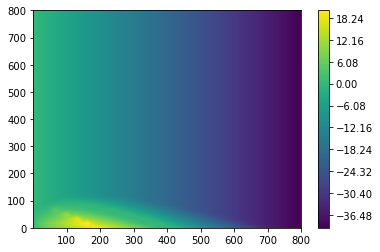

In [24]:
fig, ax = plt.subplots()
cs = ax.contourf(k_vect, a_vect, mu_k_t[:,:,0], levels = 800)
cbar = fig.colorbar(cs)

plt.show()

In [25]:
I_type_t[:,2,nT-200]

array([5., 3., 3., 3., 3., 2., 6., 6., 6., 6., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.])

In [26]:
H_t[:,2,nT-200]

array([0.31799239, 0.23461711, 0.17027872, 0.10544164, 0.05064305,
       0.10844351, 0.02282799, 0.00211422, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [27]:
mu_a_t[:,35,nT-280]

array([ 4.12082785e+01,  3.76501203e+01,  3.38520755e+01,  2.97459185e+01,
        2.52400309e+01,  2.01892286e+01,  1.43281711e+01,  6.95628890e+00,
        3.46389584e-12, -2.14798544e+00, -1.36241853e+01, -1.56337805e+01,
       -1.59526630e+01, -1.65010446e+01, -1.72057191e+01, -1.80203123e+01,
       -1.89145180e+01, -1.98678853e+01, -2.08661966e+01, -2.18992985e+01,
       -2.29597637e+01, -2.40420415e+01, -2.51419030e+01, -2.62560698e+01,
       -2.73819601e+01, -2.85175105e+01, -2.96610500e+01, -3.08112082e+01,
       -3.19668479e+01, -3.31270147e+01, -3.42908995e+01, -3.54578089e+01,
       -3.66271435e+01, -3.77983799e+01, -3.89710570e+01, -4.01447656e+01,
       -4.13191391e+01, -4.24938469e+01, -4.36685885e+01, -4.48430890e+01,
       -4.60170953e+01, -4.71903730e+01, -4.83627037e+01, -4.95338830e+01,
       -5.07037190e+01, -5.18720303e+01, -5.30386450e+01, -5.42033999e+01,
       -5.53661395e+01, -5.65267150e+01])

In [28]:
np.sum(I_unique_t[:, :, 0] > 1, axis = 0)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [29]:
I_unique_t[4, 4, 0]

0.0

In [30]:
V = V_t[:, :, 1]

# Construct forward and backward differences for a and k
dVaF[0:na-1, :] = (V[1:na, :] - V[0:na-1, :])/da
dVaF[na-1, :] = dVaF[na-2, :]

dVkF[:, 0:nk-1] = (V[:, 1:nk] - V[:, 0:nk-1])/dk
dVkF[:, nk-1] = dVkF[:, nk-2]

dVaB[1:na, :] = (V[1:na, :] - V[0:na-1, :])/da
dVaB[0, :] = dVaB[1, :]

dVkB[:, 1:nk] = (V[:, 1:nk] - V[:, 0:nk-1])/dk
dVkB[:, 0] = dVkB[:, 1]

# Compute policies and drift
cFF, hFF, xFF, mu_aFF, mu_kFF = control_drift(dVaF, dVkF, aa, kk, params)
cFB, hFB, xFB, mu_aFB, mu_kFB = control_drift(dVaF, dVkB, aa, kk, params)
cBF, hBF, xBF, mu_aBF, mu_kBF = control_drift(dVaB, dVkF, aa, kk, params)
cBB, hBB, xBB, mu_aBB, mu_kBB = control_drift(dVaB, dVkB, aa, kk, params)

# Create indicator matrices indicating consistency of direction of drift with fwd/bwd difference
# Impose False at boundary if fwd/bwd difference implies drift sends state beyond boundary
# Note that inconsistency may arise due to presence of steady-state in a or k or both dimensions. At the boundaries, these have to be checked for first before setting up reflecting boundaries, i.e., a may be already be decreasing at a_max but may show up as inconsistent if k is at steady-state, so setting up a reflecting boundary causes a to stay put instead of decreasing
I_FF = np.logical_and(mu_aFF > 0, mu_kFF > 0)
I_FF[na-1, :] = False
I_FF[:, nk-1] = False

I_FB = np.logical_and(mu_aFB > 0, mu_kFB < 0)
I_FB[na-1, :] = False
I_FB[:, 0] = False

I_BF = np.logical_and(mu_aBF < 0, mu_kBF > 0)
I_BF[0, :] = False
I_BF[:, nk-1] = False

I_BB = np.logical_and(mu_aBB < 0, mu_kBB < 0)
I_BB[0, :] = False
I_BB[:, 0] = False

# Steady-state indicator
I_SS = np.zeros((na, nk), dtype=bool)

# Compute validity of fwd/bwd difference combinations
# Stack all indicator matrices
I_stacked = np.zeros((na, nk, 5), dtype = bool)
I_stacked[:, :, 0] = I_SS
I_stacked[:, :, 1] = I_FF
I_stacked[:, :, 2] = I_FB
I_stacked[:, :, 3] = I_BF
I_stacked[:, :, 4] = I_BB

# Use logical-or over all 4 combinations; if at least one is valid, I_valid is True
I_valid = np.logical_or.reduce((I_SS, I_FF, I_FB, I_BF, I_BB))

# Check for uniqueness of valid combinations; some are not unique due to non-convexity of value function
I_unique = np.sum(I_stacked, axis = 2) <= 1

# Now perform tie-breaking by choosing combination that has largest Hamiltonian among valid combinations
# Forward and backwards Hamiltonians
H_FF = u(cFF, c_param) + uh(hFF, l_param) + mu_aFF*dVaF + mu_kFF*dVkF
H_FB = u(cFB, c_param) + uh(hFB, l_param) + mu_aFB*dVaF + mu_kFB*dVkB
H_BF = u(cBF, c_param) + uh(hBF, l_param) + mu_aBF*dVaB + mu_kBF*dVkF
H_BB = u(cBB, c_param) + uh(hBB, l_param) + mu_aBB*dVaB + mu_kBB*dVkB
H_stacked = np.zeros((na, nk, 5))
H_stacked[:, :, 0] = -np.Inf
H_stacked[:, :, 1] = H_FF
H_stacked[:, :, 2] = H_FB
H_stacked[:, :, 3] = H_BF
H_stacked[:, :, 4] = H_BB

# Take values of Hamiltonians if combination is valid; -inf otherwise
H_valid = np.where(I_stacked, H_stacked, -np.Inf)

# This selects the combination with the largest Hamiltonian among all valid combinations
I_type = np.argmax(H_valid, axis = 2)